In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

# @title Imports
import dataclasses
import datetime
import functools
import math
import re
from typing import Optional
from glob import glob

import cartopy.crs as ccrs
#from google.cloud import storage
from wofscast import autoregressive
from wofscast import casting
from wofscast import checkpoint
from wofscast import data_utils
from wofscast import my_graphcast as graphcast
from wofscast import normalization
from wofscast import rollout
from wofscast import xarray_jax
from wofscast import xarray_tree
from wofscast.data_generator import wofscast_data_generator


from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray #as xr

from wofscast.utils import count_total_parameters, save_model_params, load_model_params 

# For training the weights!
import optax
import jax
import numpy as np
import jax.numpy as jnp

from jax import device_put

from jax import pmap, device_put, local_device_count

# Check available devices
print("Available devices:", jax.devices())

from jax import tree_util

# Notes on GraphCast Changes to run with WoFS data.

# 1. Introduced time dimension with timedeltas dataset
# 2. Introduce level dimension to the dataset 
# 3. Added try/excepts for xarray_jax to avoid PyTree errors about registry 
# 4. Cuda-enabled jaxlib error; had to install jax with this command for Cuda 11.8 
# pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# 5. Need to add the forcing variables (radiation) to the dataset
# 6. Xarray 2024.1.1 raised TracerArrayConversionError, downgraded to 2023.7.0, the version 
#    used in colab in the demo notebook.


""" usage: stdbuf -oL python -u train_graphcast_with_wofs.py > & log_trainer_models & """


Available devices: [cuda(id=0), cuda(id=1)]


' usage: stdbuf -oL python -u train_graphcast_with_wofs.py > & log_trainer_models & '

In [1]:
25 * 5 + (4)

129

# Major ToDos

In [77]:
def plot_diagnostics(accum_diag, ind):
    fig, ax = plt.subplots(dpi=300, figsize=(6,4))
    for v in accum_diag.keys():
        line, = ax.plot(accum_diag[v], label=v)
        y = accum_diag[v][-1]  # Last value in the series
        x = len(accum_diag[v]) - 1  # Last index
        
        ax.annotate(v, xy=(x, y), xytext=(5,5), textcoords="offset points",
                    color=line.get_color(), fontsize=6)

            
    ax.set(xlabel='Epoch', ylabel='Loss', xlim=[0, x+5], title=f'Diagnostic Phase {ind}')
    ax.grid(alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.savefig(f'diagnostics_{ind}.png')

## GraphCast Parameters 

In [2]:
class WoFSCastTrainer:
    
    def __init__(self, 
                 mesh_size=3, 
                 latent_size=32, 
                 gnn_msg_steps=4, 
                 hidden_layers=1, 
                 grid_to_mesh_node_dist=5,
                )
        self.mesh_size = mesh_size
        self.latent_size = latent_size
    
    
    def _init_task_config(self):
    


# Initial params: mesh = 5, latent
mesh_size = 3
latent_size = 32
gnn_msg_steps = 4
hidden_layers = 1
radius_query_fraction_edge_length=5

DOMAIN_SIZE = 100

TRAIN_DATASET_PATH = '/work/mflora/wofs-cast-data/train_datasets'
NORM_STATS_PATH = '/work/mflora/wofs-cast-data/normalization_stats'

VARS_3D = ['U', 'V', 'W', 'T', 'GEOPOT']
VARS_2D = ['T2', 'COMPOSITE_REFL_10CM', 'UP_HELI_MAX', 'RAINNC']
STATIC_VARS = ['XLAND', 'HGT']

INPUT_VARS = VARS_3D + VARS_2D + STATIC_VARS
TARGET_VARS = VARS_3D + VARS_2D

EXTERNAL_FORCING_VARS = (
    "toa_incident_solar_radiation",
)
GENERATED_FORCING_VARS = (
    "year_progress_sin",
    "year_progress_cos",
    "day_progress_sin",
    "day_progress_cos",
)
FORCING_VARS = EXTERNAL_FORCING_VARS + GENERATED_FORCING_VARS

#FORCING_VARS = GENERATED_FORCING_VARS



# Not pressure levels, but just vertical array indices at the moment. 
PRESSURE_LEVELS = np.arange(0,40,2)

# Loads data from the past 20 minutes (2 steps) and 
# creates a target over the next 10-60 min. 
INPUT_DURATION = '20min'
# 170 min is the max, but keeping it lower for testing the workflow
train_lead_times = slice('10min', '60min') 

# Weights used in the loss equation.
LOSS_WEIGHTS = {v : 1.0 for v in TARGET_VARS}
#VARIABLE_WEIGHTS['W'] = 2.0
#VARIABLE_WEIGHTS['UP_HELI_MAX'] = 2.0


TASK_WOFS = graphcast.TaskConfig(
      input_variables=INPUT_VARS,
      target_variables=TARGET_VARS,
      forcing_variables=FORCING_VARS,
      pressure_levels=PRESSURE_LEVELS,
      input_duration=INPUT_DURATION,
      n_vars_2D = len(VARS_2D),
      loss_weights = LOSS_WEIGHTS,
      domain_size = DOMAIN_SIZE
  )

MODEL_CONFIG = graphcast.ModelConfig(
      resolution=0,
      mesh_size=mesh_size,
      latent_size=latent_size,
      gnn_msg_steps=gnn_msg_steps,
      hidden_layers=hidden_layers,
      radius_query_fraction_edge_length=radius_query_fraction_edge_length)

In [3]:
def create_static_vars(train_inputs):

    # Select the first time index for 'HGT' and 'XLAND' variables
    hgt_selected = train_inputs['HGT'].isel(time=0).drop('time')
    xland_selected = train_inputs['XLAND'].isel(time=0).drop('time')

    # Now, replace the 'HGT' and 'XLAND' in the original dataset with these selected versions
    train_inputs = train_inputs.drop_vars(['HGT', 'XLAND'])
    train_inputs['HGT'] = hgt_selected
    train_inputs['XLAND'] = xland_selected

    return train_inputs

In [4]:
# This data is only loaded for building the model. The true training dataset
# is loaded by the data generator below. 
train_inputs = xarray.load_dataset(os.path.join(TRAIN_DATASET_PATH , 'train_inputs_batch_0.nc'))
train_targets = xarray.load_dataset(os.path.join(TRAIN_DATASET_PATH , 'train_targets_batch_0.nc'))
train_forcings = xarray.load_dataset(os.path.join(TRAIN_DATASET_PATH , 'train_forcings_batch_0.nc'))

train_inputs = train_inputs.transpose("batch", 'time', 'lat', 'lon', 'level')
train_targets = train_targets.transpose("batch", 'time', 'lat', 'lon', 'level')
train_forcings = train_forcings.transpose("batch", 'time', 'lat', 'lon')

train_inputs = create_static_vars(train_inputs)
#train_inputs = train_inputs[VARS_3D]
#train_targets = train_targets[VARS_3D]

#train_forcings = train_forcings.drop_vars(['toa_incident_solar_radiation'])

# Load the normalization datasets
base_path = '/work/mflora/wofs-cast-data/normalization_stats'
mean_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'mean_by_level.nc'))
stddev_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'stddev_by_level.nc'))
diffs_stddev_by_level = xarray.load_dataset(os.path.join(NORM_STATS_PATH, 'diffs_stddev_by_level.nc'))

In [5]:
print("*"*80)
print("Train Inputs:  ", train_inputs.dims.mapping)
print("Train Targets: ", train_targets.dims.mapping)
print("Train Forcings:", train_forcings.dims.mapping)
print("*"*80)

********************************************************************************
Train Inputs:   {'batch': 32, 'time': 2, 'lat': 100, 'lon': 100, 'level': 20}
Train Targets:  {'batch': 32, 'time': 6, 'level': 20, 'lat': 100, 'lon': 100}
Train Forcings: {'batch': 32, 'time': 6, 'lat': 100, 'lon': 100}
********************************************************************************


In [9]:
def construct_wrapped_graphcast(model_config: graphcast.ModelConfig, task_config: graphcast.TaskConfig):
    """Constructs and wraps the GraphCast Predictor."""
    # Deeper one-step predictor.
    predictor = graphcast.GraphCast(model_config, task_config)

    # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
    # from/to float32 to/from BFloat16.
    predictor = casting.Bfloat16Cast(predictor)

    # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
    # BFloat16 happens after applying normalization to the inputs/targets.
    predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)

    # Wraps everything so the one-step model can produce trajectories.
    predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
    
    return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
    predictor = construct_wrapped_graphcast(model_config, task_config)
    loss, diagnostics = predictor.loss(inputs, targets, forcings)
    return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
    def _aux(params, state, i, t, f):
        (loss, diagnostics), next_state = loss_fn.apply(
            params, state, jax.random.PRNGKey(0), model_config, task_config,
            i, t, f)
        return loss, (diagnostics, next_state)
      
        (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
          _aux, has_aux=True)(params, state, inputs, targets, forcings)
    return loss, diagnostics, next_state, grads

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
  return functools.partial(
      fn, model_config=MODEL_CONFIG, task_config=TASK_WOFS)

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=model_params, state=state)

# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

model_params, state = init_jitted(
    rng=jax.random.PRNGKey(0),
    inputs=train_inputs,
    targets_template=train_targets,
    forcings=train_forcings)

num = count_total_parameters(model_params)

print(f'Num of Parameters: {num}')

In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Num of Parameters: 72712


In [10]:
# TODO: Keep track of the diagnostics 

Starting Phase 1 learning...
Training with a linearly increasing learning rate from 1e-06 to 0.001

In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Phase 1 Epoch: 0.....Loss: 8.18043
Phase 1 Epoch: 1.....Loss: 8.19958
Starting Phase 2 learning...

Training with a cosine decaying schedule...
Phase 2 Epoch: 0.....Loss: 8.15291
Phase 2 Epoch: 1.....Loss: 8.07014
Starting Phase 3 learning...

 Fine tuning the model by training on longer predictions...
In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Phase 3 Epoch: 0.....Loss: 11.90952
In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Phase 3 Epoch: 1.....Loss: 15.71985
In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Phase 3 Epoch: 2.....Loss: 19.58543
In my_graphcast, Line 816 Excluding forcings!!
In my_graphcast, Line 816 Excluding forcings!!
Phase 3 Epoch: 3..

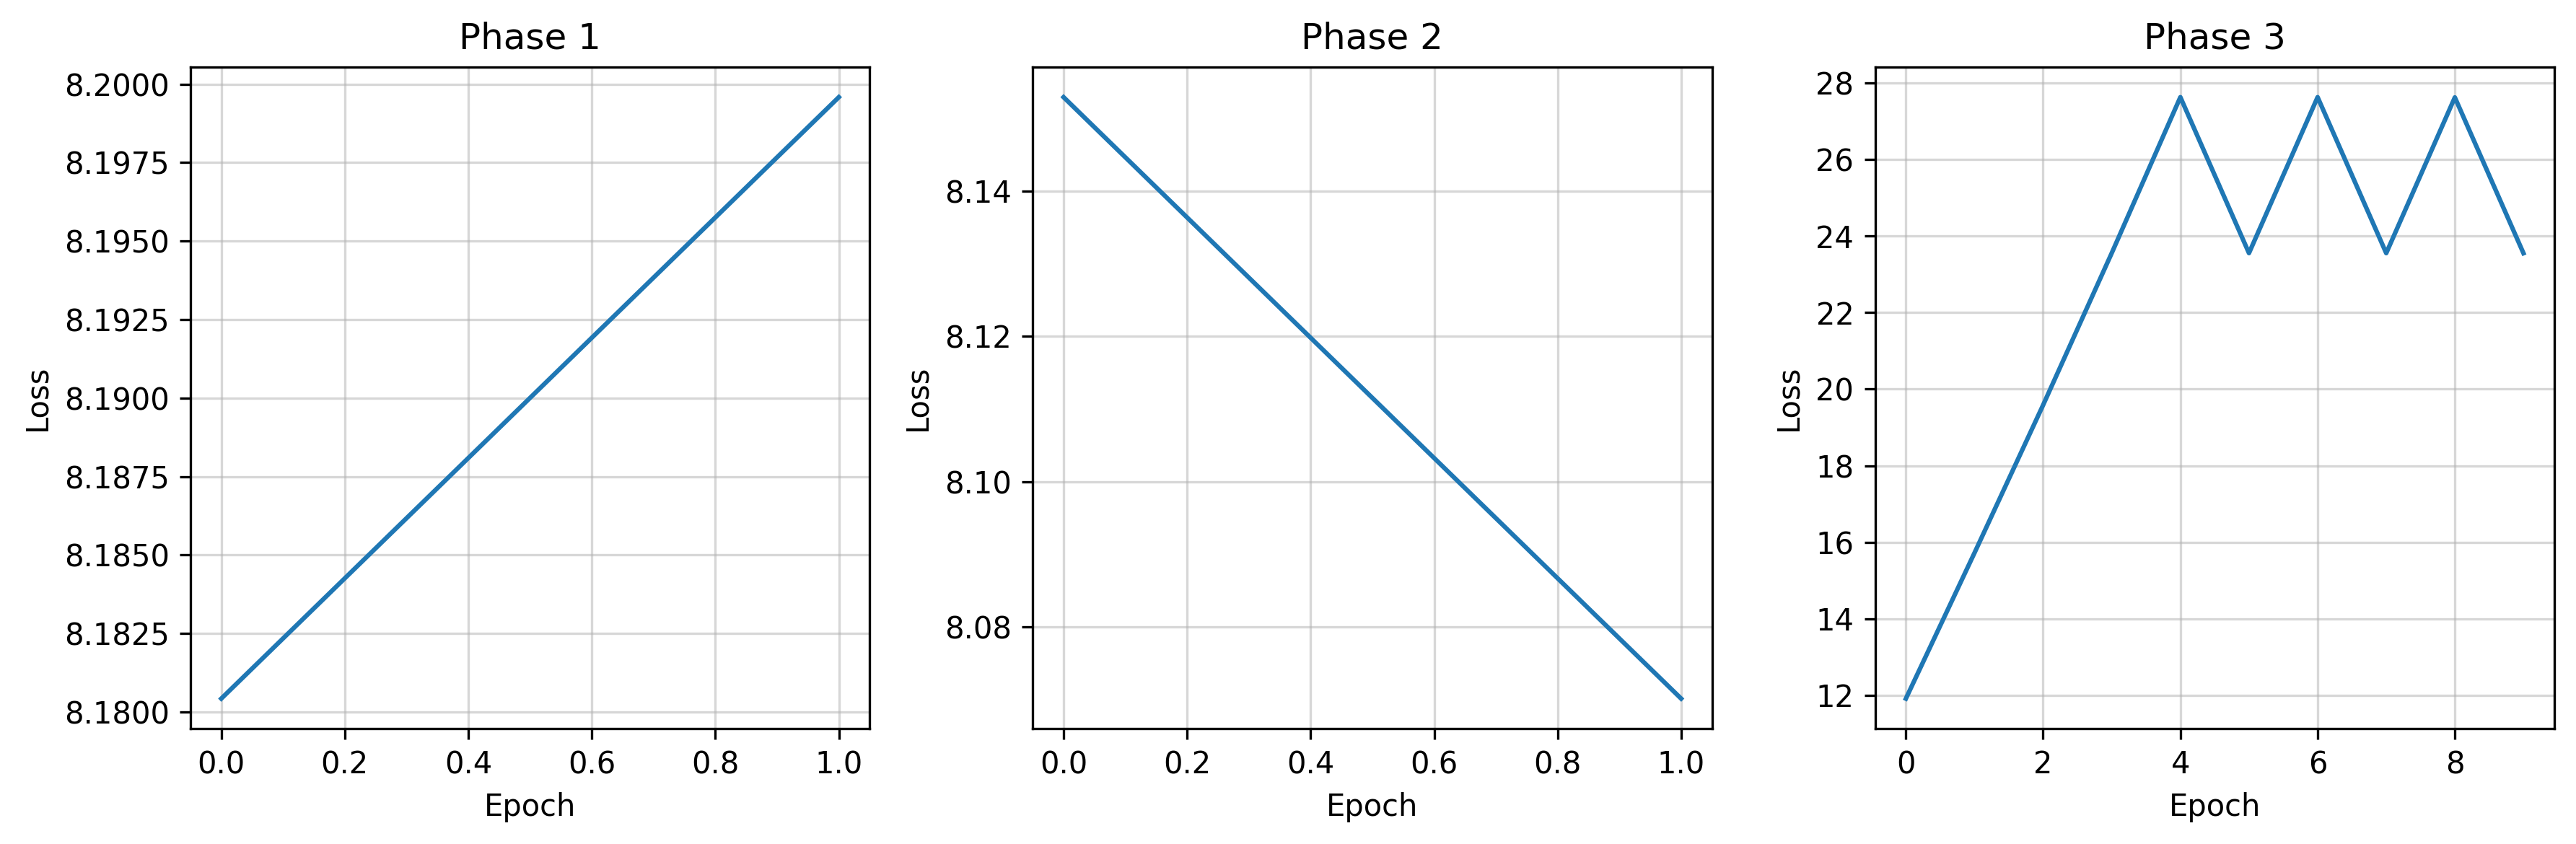

In [33]:
# Define the gradient function

def grads_fn(params, state, inputs, targets, forcings, model_config, task_config):
    def compute_loss(params, state, inputs, targets, forcings):
        (loss, diagnostics), next_state = loss_fn.apply(params, state, 
                                                        jax.random.PRNGKey(0), 
                                                        model_config, 
                                                        task_config, 
                                                        inputs, targets, forcings)
        return loss, (diagnostics, next_state)
    
    # Compute gradients and auxiliary outputs
    (loss, (diagnostics, next_state)), grads = jax.value_and_grad(compute_loss, has_aux=True)(params, state, 
                                                                                              inputs, targets, 
                                                                                              forcings)
    
    # Compute the global norm of all gradients
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in tree_util.tree_leaves(grads)))

    # Clip gradients if the total norm exceeds the threshold
    def clip_grads(g, clip_norm=32):
        return jnp.where(total_norm > clip_norm, g * clip_norm / total_norm, g)

    clipped_grads = tree_util.tree_map(clip_grads, grads)

    
    return loss, diagnostics, next_state, grads

#grads_fn_jitted = jax.jit(with_configs(grads_fn))

train_step_jitted = jax.jit(with_configs(grads_fn))

def update_step(optimiser, params, grads, opt_state):
    """Performs a single update step by applying gradients to parameters."""
    updates, opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

def add_diagnostics(accum_diagnostic, diagnostics, ind): 
    """Append the diagnostics from each epoch"""
    for var, val in diagnostics.items():
        accum_diagnostics[var][ind] = float(val)
  
    return accum_diagnostics

def compute_avg_diagnostics(diag_list, target_vars):
    temp_dict = {v : [] for v in target_vars}
    for diag in diag_list: 
        for v in target_vars:
            temp_dict[v].append(float(diag[v]))
            
    final_dict = {v: np.mean(temp_dict[v]) for v in target_vars}

    return final_dict

# Training Parameters. 
TOTAL_LINEAR_EPOCHS = 2
TOTAL_COSINE_EPOCHS = 2
TOTAL_FINAL_EPOCHS = 10 

NT = len(train_targets['time'])
FINAL_EPOCH_INTERVAL = TOTAL_FINAL_EPOCHS // NT

#BATCH_SIZE = 32
N_BATCHES = 3
checkpoint = False

# Setup the learning rate schedule
start_learning_rate = 1e-6  # Start from 0
end_learning_rate = 1e-3  # Increase to 1e-3
schedule = optax.linear_schedule(init_value=start_learning_rate, 
                                 end_value=end_learning_rate, 
                                 transition_steps=TOTAL_LINEAR_EPOCHS)

base_path = '/work/mflora/wofs-cast-data/model/checkpoints'
params_path = os.path.join(base_path, 'params.npz')

training_loss_phase1 = np.zeros((TOTAL_LINEAR_EPOCHS))
training_loss_phase2 = np.zeros((TOTAL_COSINE_EPOCHS))
training_loss_phase3 = np.zeros((TOTAL_FINAL_EPOCHS))

accum_diagnostics1 = {v : np.zeros(TOTAL_LINEAR_EPOCHS) for v in TARGET_VARS}
accum_diagnostics2 = {v : np.zeros(TOTAL_COSINE_EPOCHS) for v in TARGET_VARS}
accum_diagnostics3 = {v : np.zeros(TOTAL_FINAL_EPOCHS) for v in TARGET_VARS}

# Training loop with linearly increasing learning rate
print('Starting Phase 1 learning...')
print(f'Training with a linearly increasing learning rate from {start_learning_rate} to {end_learning_rate }\n')
for epoch in range(TOTAL_LINEAR_EPOCHS): 
    # Get the current learning rate from the schedule
    lr = schedule(epoch)
    # Setup optimizer with the current learning rate
    optimiser = optax.adam(lr, b1=0.9, b2=0.95, eps=1e-8)
    if epoch == 0:
        # Initialize the optimizer state only at the beginning
        opt_state = optimiser.init(model_params)
    
    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    diag_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES):

        loss, diagnostics, next_state, grads = train_step_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        diag_per_epoch.append(diagnostics)
        
        # Update parameters
        model_params, opt_state = update_step(optimiser, model_params, grads, opt_state)
    
    # Every 50 epoches, save the model_params
    if epoch % 50 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)
            
    avg_diag = compute_avg_diagnostics(diag_per_epoch, TARGET_VARS)
    accum_diagnostics1 = add_diagnostics(accum_diagnostics1, avg_diag, epoch)
    
    print(f"Phase 1 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase1[epoch] = np.mean(losses_per_epoch)
        
# Initialize the cosine decay schedule from Optax
print('Starting Phase 2 learning...')
print('\nTraining with a cosine decaying schedule...')
cosine_schedule = optax.cosine_decay_schedule(init_value=1e-3, 
                                                  decay_steps=TOTAL_COSINE_EPOCHS, 
                                                  alpha=0)  # alpha=0 makes it decay to 0        

# Training loop with decaying learning rate
for epoch in range(TOTAL_COSINE_EPOCHS): 
    # Get the current learning rate from the schedule
    lr = cosine_schedule(epoch)
    # Setup optimizer with the current learning rate
    optimiser = optax.adam(lr, b1=0.9, b2=0.95, eps=1e-8)

    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    diag_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES):
        loss, diagnostics, next_state, grads = train_step_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        diag_per_epoch.append(diagnostics)
        
        # Update parameters
        model_params, opt_state = update_step(optimiser, model_params, grads, opt_state)
        
    print(f"Phase 2 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase2[epoch] = np.mean(losses_per_epoch)
    avg_diag = compute_avg_diagnostics(diag_per_epoch, TARGET_VARS)
    accum_diagnostics2 = add_diagnostics(accum_diagnostics2, avg_diag, epoch)
    
    # Every 50 epoches, save the model_params
    if epoch % 1000 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)

print('Starting Phase 3 learning...')
print('\n Fine tuning the model by training on longer predictions...')

# Setup optimizer with the current learning rate
optimiser = optax.adam(3e-7, b1=0.9, b2=0.95, eps=1e-8)

n_timesteps = 1 
for epoch in range(TOTAL_FINAL_EPOCHS):
    
    # Steadily increase the lead time evaluated. 
    if epoch % FINAL_EPOCH_INTERVAL == 0: 
        n_timesteps+=1
        if n_timesteps > NT:
            n_timesteps = NT-1

    # Create mini-batches for the current epoch and compute gradients. 
    losses_per_epoch = []
    diag_per_epoch = []
    for batch_inputs, batch_targets, batch_forcings in data_generator(N_BATCHES, n_timesteps): 
        loss, diagnostics, next_state, grads = train_step_jitted(model_params, state, batch_inputs, 
                                                           batch_targets, batch_forcings)
        losses_per_epoch.append(loss)
        diag_per_epoch.append(diagnostics)
        
        # Update parameters
        model_params, opt_state = update_step(optimiser, model_params, grads, opt_state)
        
    print(f"Phase 3 Epoch: {epoch}.....Loss: {np.mean(losses_per_epoch):.5f}")
    training_loss_phase3[epoch] = np.mean(losses_per_epoch)
    avg_diag = compute_avg_diagnostics(diag_per_epoch, TARGET_VARS)
    accum_diagnostics3 = add_diagnostics(accum_diagnostics3, avg_diag, epoch)
    
    # Every 50 epoches, save the model_params
    if epoch % 1000 == 0 and checkpoint:
        print('Saving model params....')
        save_model_params(model_params, params_path)

# Final model
base_path = '/work/mflora/wofs-cast-data/model/'
params_path = os.path.join(base_path, 'params.npz')
save_model_params(model_params, params_path)

fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(12,4))
titles = ['Phase 1', 'Phase 2', 'Phase 3']
for i, (ax, loss) in enumerate(zip(axes.flat, [training_loss_phase1, 
                                               training_loss_phase2, training_loss_phase3])):
    ax.set(ylabel='Loss', xlabel='Epoch', title=titles[i])
    ax.plot(loss)
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.savefig('training_results.png')

# Save the diagnostics. 
plot_diagnostics(accum_diagnostics1, 1)
plot_diagnostics(accum_diagnostics2, 2)
plot_diagnostics(accum_diagnostics3, 3)